In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
kagglehub.competition_download('aptos2019-blindness-detection')

100%|██████████| 9.51G/9.51G [01:47<00:00, 94.7MB/s]

Extracting files...


'/root/.cache/kagglehub/competitions/aptos2019-blindness-detection'

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns

# Seeds
TRAIN_TEST_SPLIT_SEED = 564258
TRAIN_VAL_SPLIT_SEED = 123456

# Config
TEST_PERCENT = 0.2
VAL_PERCENT = 0.2

# File paths
BASEDIR = '/root/.cache/kagglehub/competitions/aptos2019-blindness-detection'
IMAGESDIR = f'{BASEDIR}/train_images'

# All labels
labels_df = pd.read_csv(f'{BASEDIR}/train.csv')
labels_df = labels_df.set_index('id_code')
labels_df.head()

,diagnosis
id_code,
000c1434d8d7,2
001639a390f0,4
0024cdab0c1e,1
002c21358ce6,0
005b95c28852,0


In [ ]:
train_labels_df, test_labels_df = train_test_split(labels_df, test_size=TEST_PERCENT, random_state=TRAIN_TEST_SPLIT_SEED, stratify=labels_df['diagnosis'])
print(f'Number of train instances: {len(train_labels_df)}')
print(f'Number of test instances: {len(test_labels_df)}')
train_labels_df.to_csv(f'train_labels.csv')
test_labels_df.to_csv(f'test_labels.csv')

Number of train instances: 2929
Number of test instances: 733


y distribution (train): diagnosis
0    1444
1     296
2     799
3     154
4     236
Name: count, dtype: int64
y distribution (test): diagnosis
0    361
1     74
2    200
3     39
4     59
Name: count, dtype: int64


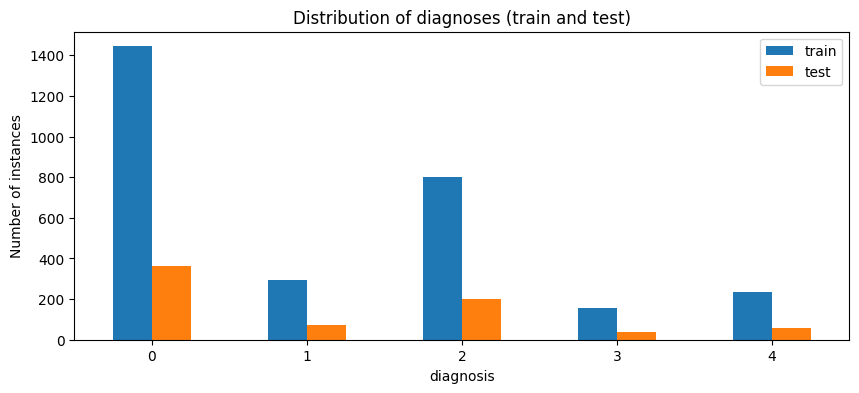

In [ ]:
# y distribution
y_dist_train = train_labels_df['diagnosis'].value_counts().sort_index()
y_dist_test = test_labels_df['diagnosis'].value_counts().sort_index()
print('y distribution (train):', y_dist_train)
print('y distribution (test):', y_dist_test)

# plot distributions
combined_y_dist = pd.DataFrame({'train': y_dist_train, 'test': y_dist_test})
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
combined_y_dist.plot(kind='bar', stacked=False, ax=ax, title='Distribution of diagnoses (train and test)', rot=0)
ax.set_ylabel('Number of instances')
plt.show()

In [ ]:
from tensorflow import keras

# Global Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
PATIENCE = 8
SEEDS = [564258, 564307, 564322]
NUM_CLASSES = 5

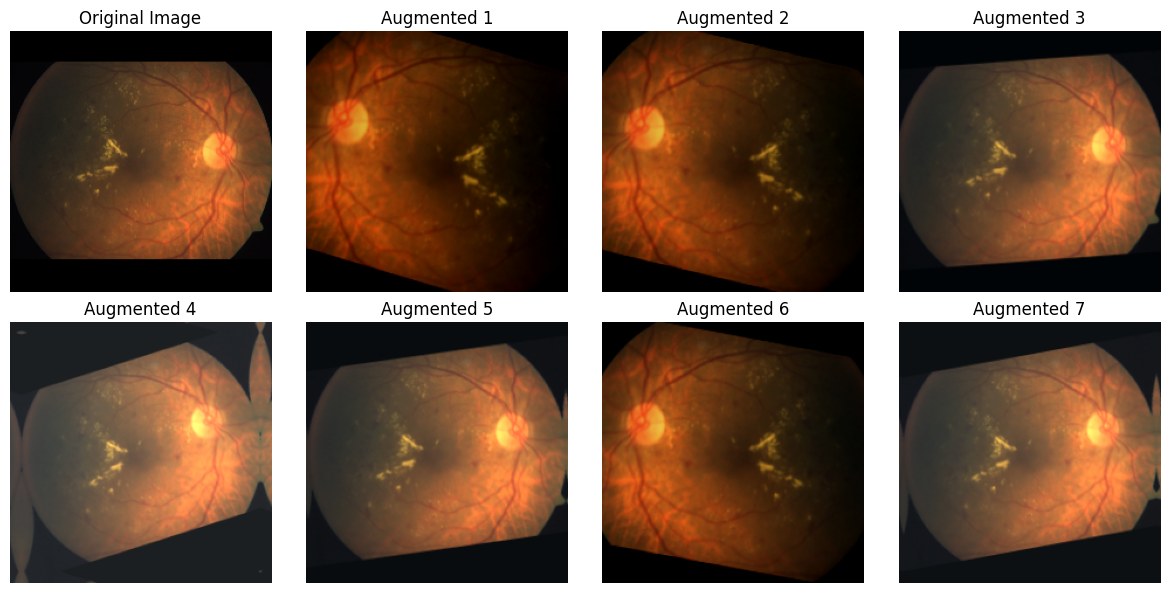

In [ ]:
# Preprocessing & Augmentation
def get_data_augmentation(seed):
    return keras.models.Sequential([
        keras.layers.RandomFlip("horizontal", seed=seed),
        keras.layers.RandomRotation(0.05, seed=seed),
        keras.layers.RandomZoom(height_factor=(-0.2, 0.1), seed=seed),
        keras.layers.RandomBrightness(factor=0.15, seed=seed),
        keras.layers.RandomContrast(factor=0.15, seed=seed)
    ], name="data_augmentation")

data_augmentation = get_data_augmentation(seed=SEEDS[2])

# Define a function to load and preprocess a single image for visualization
def load_and_preprocess_image(path, label=None):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    # No normalization here, keep original pixel values for display
    return img, label

# Get a random image path from the training set
rng = np.random.default_rng(seed=SEEDS[0])
random_index = rng.integers(0, len(train_labels_df) - 1)
random_image_id = train_labels_df.index[random_index]
random_image_path = f"{IMAGESDIR}/{random_image_id}.png"

# Load and preprocess the original image
original_image, _ = load_and_preprocess_image(random_image_path)

# Create a figure to display the images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

# Display the original image
axes[0].imshow(original_image.numpy().astype("uint8"))
axes[0].set_title("Original Image")
axes[0].axis("off")

# Display augmented images
for i in range(1, 8):
    augmented_image = data_augmentation(tf.expand_dims(original_image, 0), training=True)
    # Remove the batch dimension and convert to uint8 for display
    axes[i].imshow(augmented_image[0].numpy().astype("uint8"))
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


STARTING RUN WITH SEED: 564258

Building training dataset...
Training dataset is ready!

Building validation dataset...
Validation dataset is ready!

--- Training model for seed 564258 ---
Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.5502 - loss: 1.2603 - val_accuracy: 0.7338 - val_loss: 0.7900
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 51s 433ms/step - accuracy: 0.6827 - loss: 0.8700 - val_accuracy: 0.7594 - val_loss: 0.7404
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 31s 416ms/step - accuracy: 0.7246 - loss: 0.7457 - val_accuracy: 0.7611 - val_loss: 0.6927
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 42s 425ms/step - accuracy: 0.7460 - loss: 0.6779 - val_accuracy: 0.7594 - val_loss: 0.6712
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 40s 410ms/step - accuracy: 0.7517 - loss: 0.7014 - val_accuracy: 0.7543 - val_loss: 0.6796
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 31s 418ms/step - accuracy: 0.7524 - loss: 0.6628 - val_accuracy: 0.7372 - val_loss: 0.7010
Epoch 7/100
74/74 ━━━━━━━━━━━━━━

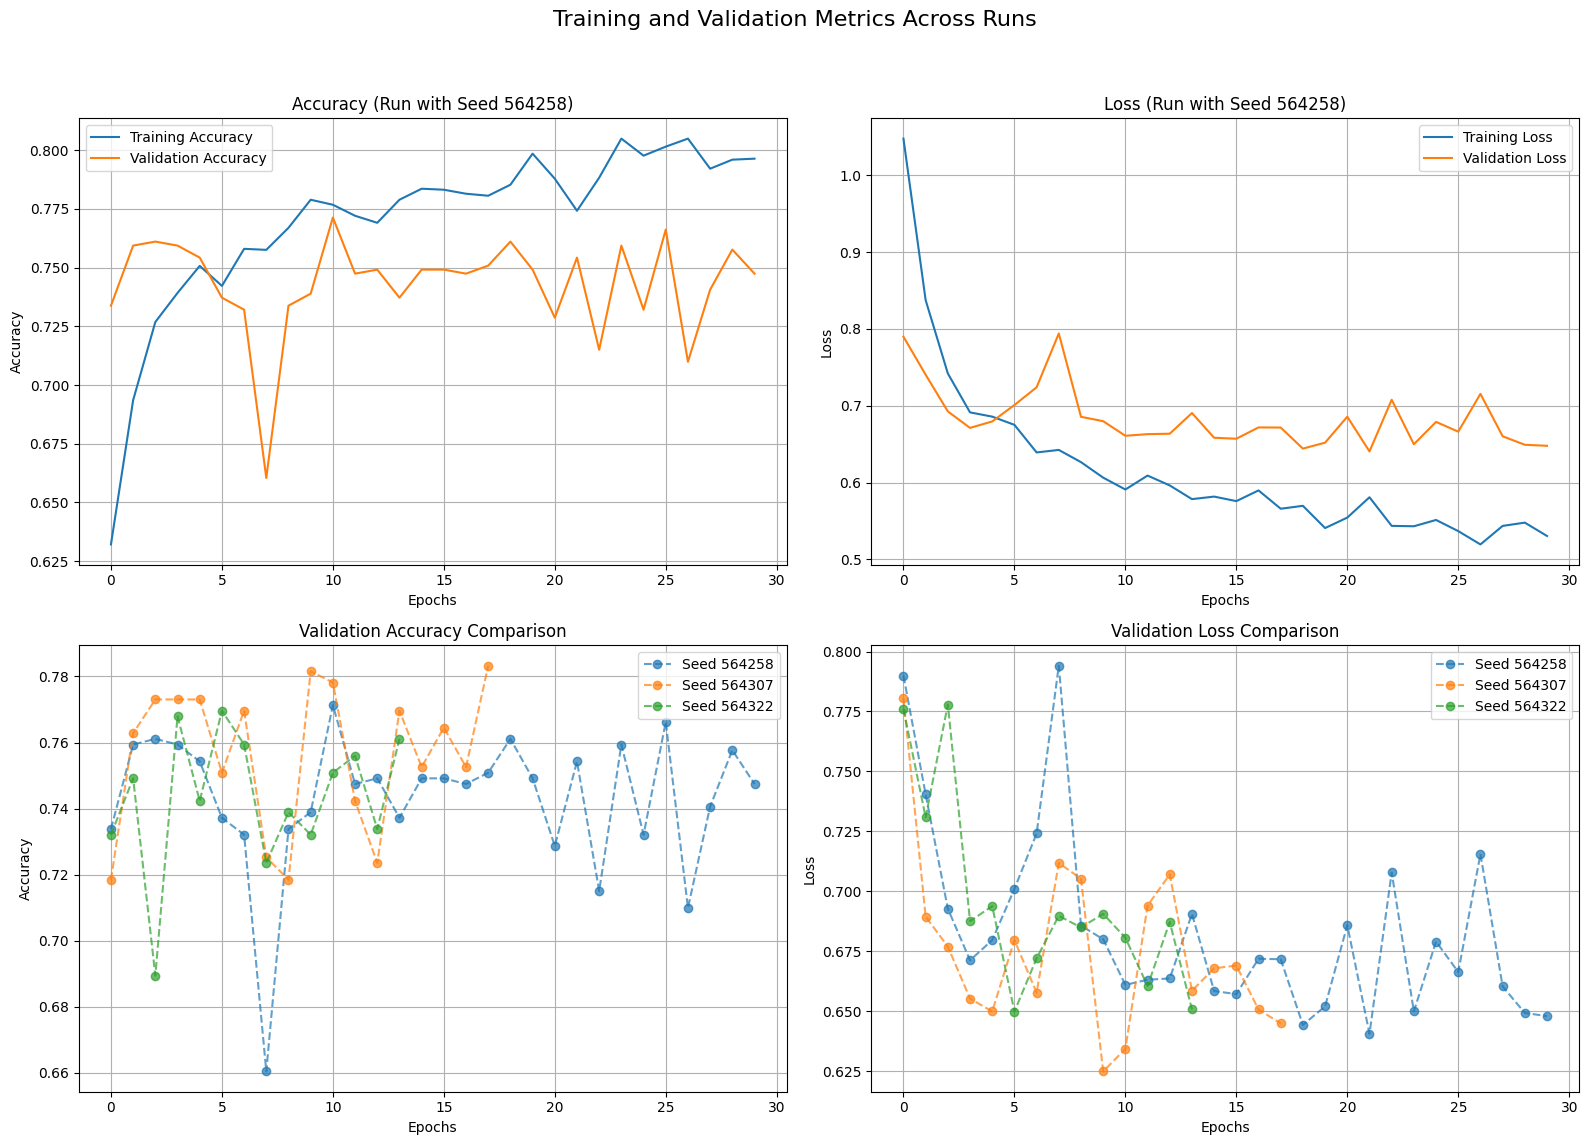

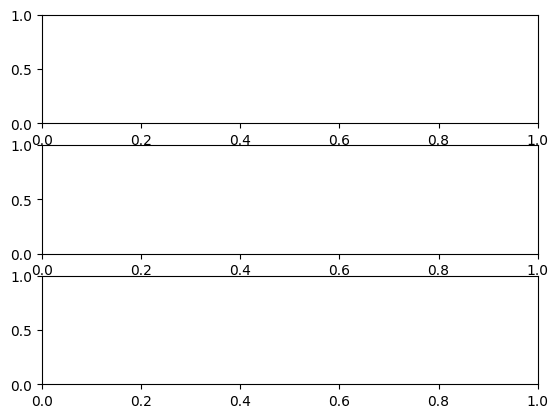

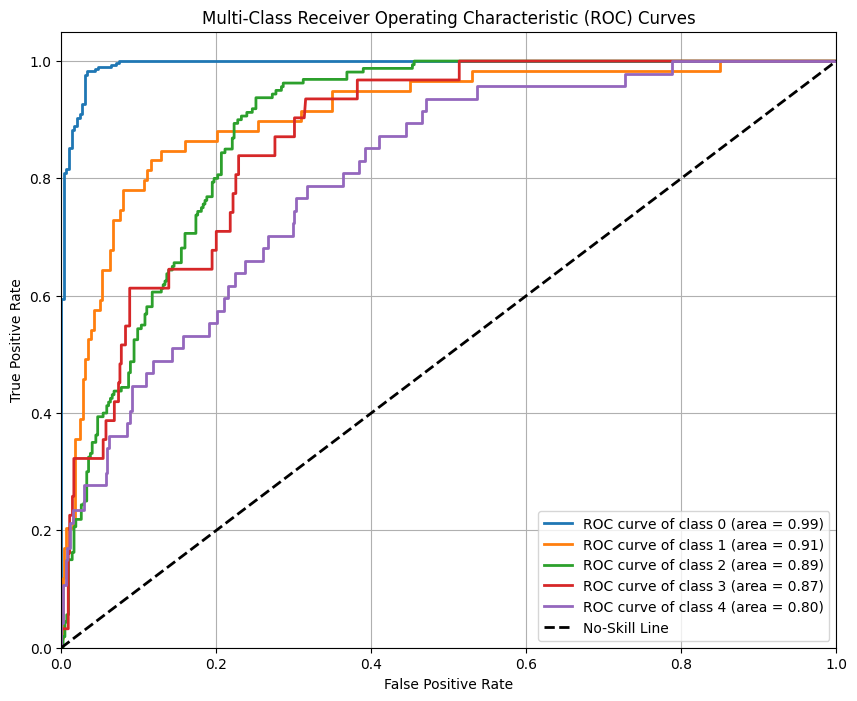

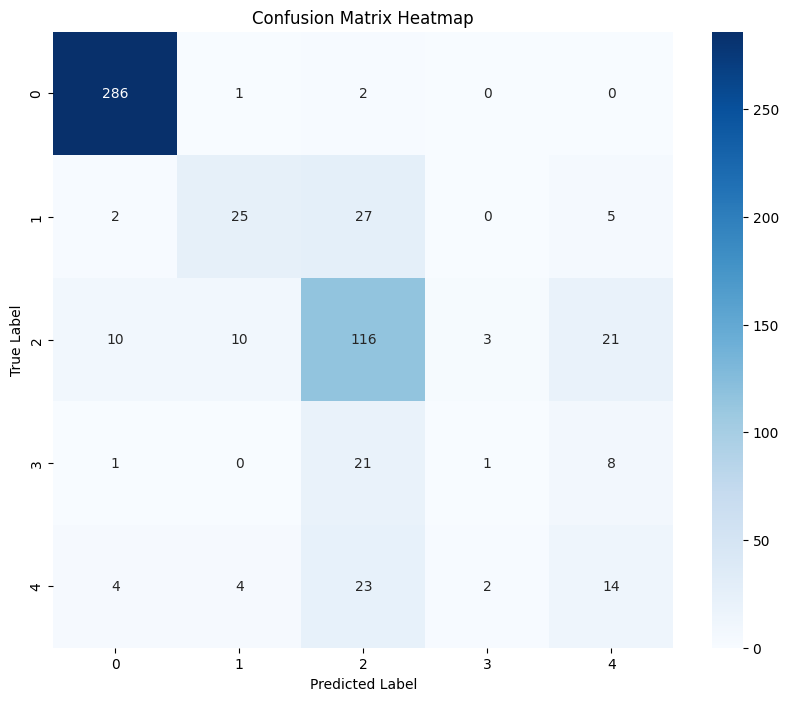

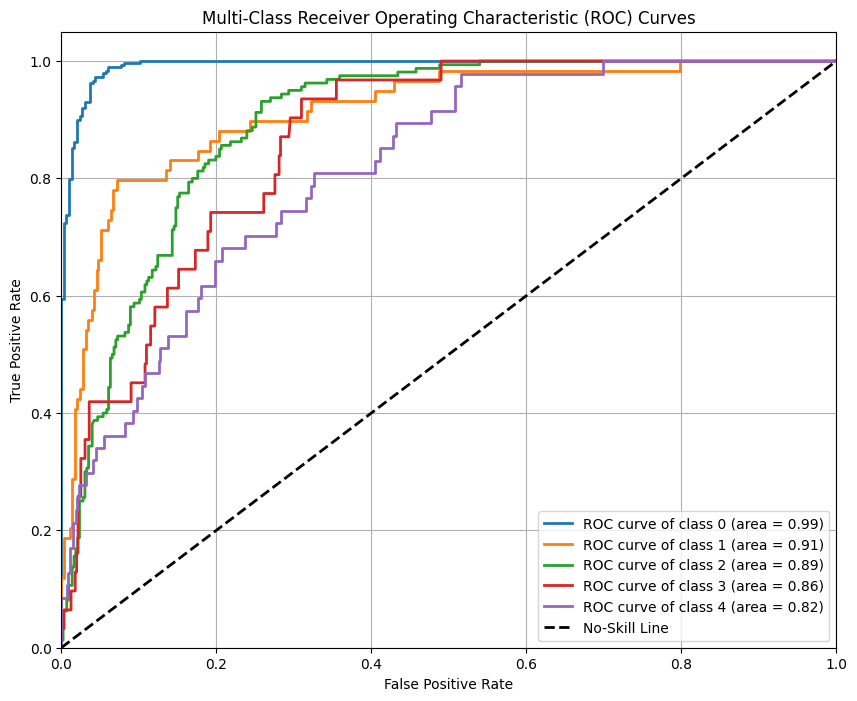

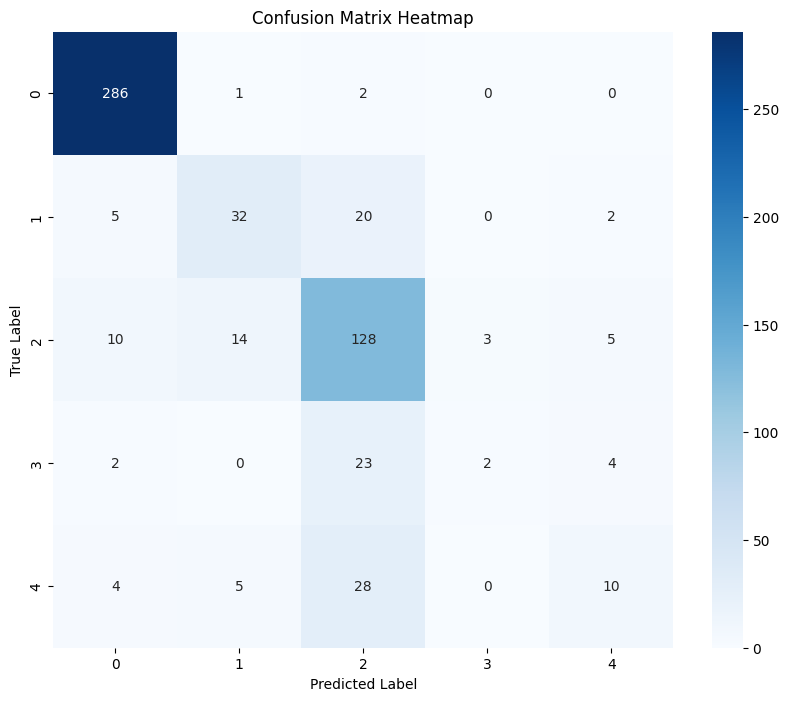

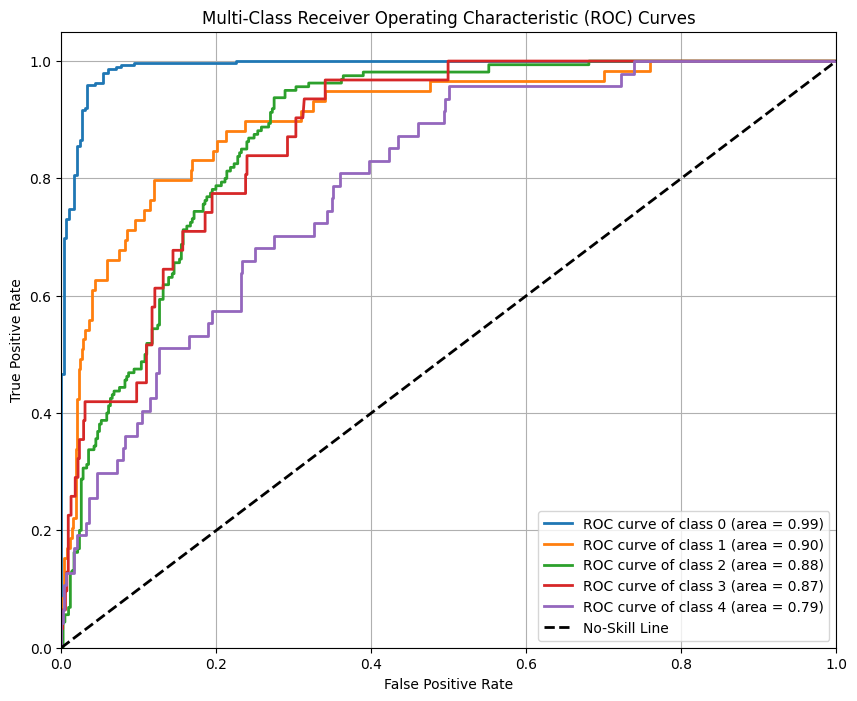

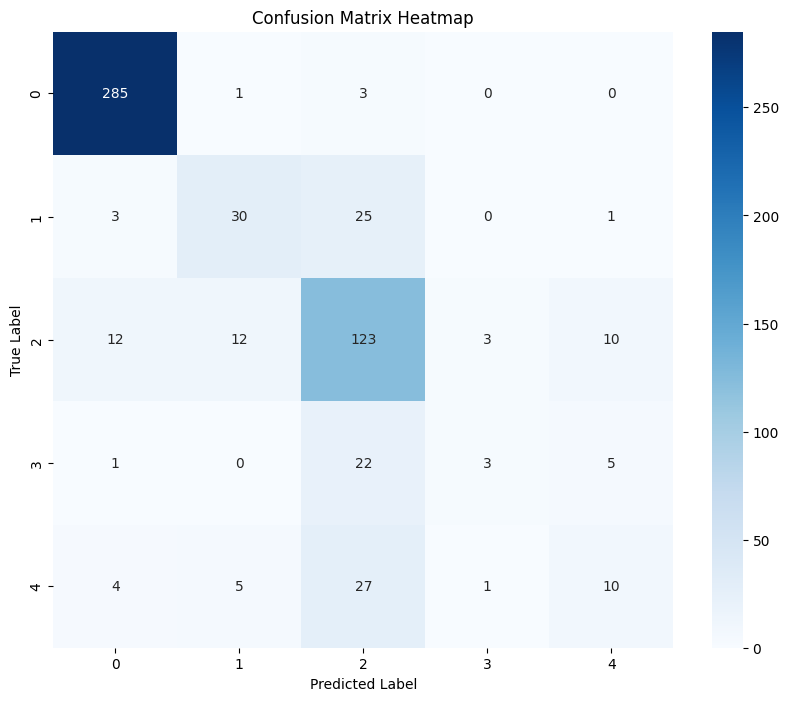

In [ ]:
# Train/validation split
image_paths = train_labels_df.index.map(lambda x: f"{IMAGESDIR}/{x}.png").to_list()
diagnostics = train_labels_df['diagnosis'].to_list()
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, diagnostics, test_size=VAL_PERCENT, random_state=TRAIN_VAL_SPLIT_SEED, stratify=diagnostics
)

# Experiment function
def run_experiment(seed):
    print(f"\n{'='*60}")
    print(f"STARTING RUN WITH SEED: {seed}")
    print(f"{'='*60}")

    # Set all seeds for full reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    AUTOTUNE = tf.data.AUTOTUNE

    data_augmentation = get_data_augmentation(seed=seed)

    # Apply augmentations and final transformations
    def augment_and_normalize(image, label):
        image = data_augmentation(image, training=True)
        image = image / 255.0
        return image, label

    # Prepare training data
    print("\nBuilding training dataset...")
    train_ds = (
        tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
        .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
        .cache()
        .shuffle(buffer_size=len(train_paths), seed=seed)
        .map(augment_and_normalize)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )
    print("Training dataset is ready!")

    # Prepare validation data
    print("\nBuilding validation dataset...")
    validation_ds = (
        tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
        .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
        .map(lambda img, lbl: (img / 255.0, lbl)) # Just normalize, no augmentation
        .cache()
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )
    print("Validation dataset is ready!")

    # Compile model
    base_model = keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.Dropout(0.3, seed=seed)(x) # Pass seed to Dropout for reproducibility
    outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = keras.models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks/Monitoring
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=1)
    model_checkpoint_path = f'best_model_seed_{seed}.keras'
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=model_checkpoint_path, save_best_only=True, monitor='val_loss', mode='min'
    )

    # Training
    print(f"\n--- Training model for seed {seed} ---")
    history = model.fit(
        train_ds,
        epochs=NUM_EPOCHS,
        validation_data=validation_ds,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # Evaluation
    print(f"\n--- Evaluating best model for seed {seed} from {model_checkpoint_path} ---")
    best_model = keras.models.load_model(model_checkpoint_path)
    print("Generating predictions on the validation set...")
    # Get the raw probability predictions
    raw_predictions = best_model.predict(validation_ds)
    # Convert probabilities to class labels (0, 1, 2, 3, 4)
    y_pred = np.argmax(raw_predictions, axis=1)
    # Extract the true labels from the validation dataset
    y_true = np.concatenate([y for x, y in validation_ds], axis=0)
    print("Calculating evaluation metrics...")

    # Cohen's Kappa (Quadratic Weighted)
    kappa = sklearn.metrics.cohen_kappa_score(y_true, y_pred, weights='quadratic')

    # F1, Precision, Recall
    # Using output_dict=True to easily access the values
    report = sklearn.metrics.classification_report(y_true, y_pred, output_dict=True)
    # We'll use the weighted average, which accounts for class imbalance
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    auc_score = sklearn.metrics.roc_auc_score(y_true, raw_predictions, multi_class='ovr')
    auc_by_class = sklearn.metrics.roc_auc_score(y_true, raw_predictions, multi_class='ovr', average=None)

    # Basic loss and accuracy from model.evaluate
    final_scores = best_model.evaluate(validation_ds, verbose=0)

    print(f"\nResults for Seed {seed}:")
    print(f"  - Validation Loss: {final_scores[0]:.4f}")
    print(f"  - Validation Accuracy: {final_scores[1]:.4f}")
    print(f"  - Quadratic Weighted Kappa: {kappa:.4f}")
    print(f"  - Weighted F1-Score: {f1_score:.4f}")
    print(f"  - Weighted Precision: {precision:.4f}")
    print(f"  - Weighted Recall: {recall:.4f}")
    print(f"  - AUC Score (ovr): {auc_score:.4f}")
    print(f"  - AUC Score by Class: {auc_by_class}")

    return {
        'seed': seed,
        'history': history.history,
        'val_loss': final_scores[0],
        'val_accuracy': final_scores[1],
        'kappa': kappa,
        'f1_score': f1_score,
        'precision': precision,
        'recall': recall,
        'auc_score': auc_score,
        'auc_by_class': auc_by_class,
        'y_true': y_true,
        'raw_predictions': raw_predictions,
        'full_report': report
    }


all_results = []
for seed_value in SEEDS:
    result = run_experiment(seed_value)
    all_results.append(result)

print(f"\n{'='*60}")
print("FINAL RESULTS ACROSS ALL RUNS")
print(f"{'='*60}")
print("Parameters used:")
print(f"  - Learning Rate: {LEARNING_RATE}")
print(f"  - Epochs: Up to {NUM_EPOCHS} (with Early Stopping patience={PATIENCE})")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Seeds: {SEEDS}")

results_df = pd.DataFrame(all_results)
metric_columns = ['seed', 'val_loss', 'val_accuracy', 'kappa', 'f1_score', 'precision', 'recall']
print("\n--- Per-run Metrics ---")
print(results_df[metric_columns].round(4))

print("\n--- Summary Statistics (Média e Desvio-Padrão) ---")
summary_cols = ['val_loss', 'val_accuracy', 'kappa', 'f1_score', 'precision', 'recall']
summary = results_df[summary_cols].agg(['mean', 'std'])
print(summary.round(4))


# Gráficos de acurácia e loss
print("\n== Generating Plots ==")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Training and Validation Metrics Across Runs', fontsize=16)

# Plot Training & Validation Accuracy for one representative run (e.g., the first one)
axes[0, 0].plot(all_results[0]['history']['accuracy'], label='Training Accuracy')
axes[0, 0].plot(all_results[0]['history']['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title(f'Accuracy (Run with Seed {all_results[0]["seed"]})')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot Training & Validation Loss for one representative run
axes[0, 1].plot(all_results[0]['history']['loss'], label='Training Loss')
axes[0, 1].plot(all_results[0]['history']['val_loss'], label='Validation Loss')
axes[0, 1].set_title(f'Loss (Run with Seed {all_results[0]["seed"]})')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot Validation Accuracy across all runs to show stability
for result in all_results:
    axes[1, 0].plot(result['history']['val_accuracy'], 'o--', alpha=0.7, label=f"Seed {result['seed']}")
axes[1, 0].set_title('Validation Accuracy Comparison')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot Validation Loss across all runs to show stability
for result in all_results:
    axes[1, 1].plot(result['history']['val_loss'], 'o--', alpha=0.7, label=f"Seed {result['seed']}")
axes[1, 1].set_title('Validation Loss Comparison')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ROC Curves
roc_fig, roc_axs = plt.subplots(3, 1)
for result in all_results:
    y_true = result['y_true']
    raw_predictions = result['raw_predictions']
    y_pred = np.argmax(raw_predictions, axis=1)
    # --- Plot 1: Multi-Class ROC Curves ---
    # Setup for the plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Store the FPR, TPR, and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calculate the ROC curve and AUC for each class (One-vs-Rest)
    for i in range(NUM_CLASSES):
        # Create binary true labels for the current class
        y_true_class = (y_true == i).astype(int)
        # Get the model's scores for the current class
        y_score_class = raw_predictions[:, i]

        fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_true_class, y_score_class)
        roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

    # Plot each class's ROC curve
    for i in range(NUM_CLASSES):
        ax.plot(fpr[i], tpr[i], lw=2,
                label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

    # Plot the "no-skill" line
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='No-Skill Line')

    # Final plot settings
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Multi-Class Receiver Operating Characteristic (ROC) Curves')
    ax.legend(loc="lower right")
    ax.grid(True)
    plt.show()


    # --- Plot 2: Confusion Matrix Heatmap ---

    # Calculate the confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)

    # Create a figure for the heatmap
    plt.figure(figsize=(10, 8))

    # Use seaborn to create a heatmap
    sns.heatmap(cm,
                annot=True,     # Show the numbers in each cell
                fmt='d',        # Format the numbers as integers
                cmap='Blues',   # Color scheme
                xticklabels=range(NUM_CLASSES),
                yticklabels=range(NUM_CLASSES))

    plt.title('Confusion Matrix Heatmap')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [ ]:
for result in all_results:
    seed = result['seed']
    y_true = result['y_true']
    raw_predictions = result['raw_predictions']
    y_pred = np.argmax(raw_predictions, axis=1)

    print(f"--- Results for Seed: {seed} ---")

    # Use classification_report to get detailed metrics
    # Set output_dict=True to get a dictionary that's easy to work with
    report = sklearn.metrics.classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    # Create a list to hold the data for our table
    class_metrics = []

    # Iterate through each class found in the report
    # We skip the summary keys like 'accuracy', 'macro avg', 'weighted avg'
    for class_label, metrics in report.items():
        if class_label.isdigit(): # Check if the key is a class label (e.g., '0', '1', ...)
            class_metrics.append({
                'Class': int(class_label),
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'F1-Score': metrics['f1-score'],
                'Support': metrics['support'] # Number of true instances in this class
            })

    # Convert the list of dictionaries to a pandas DataFrame for nice printing
    metrics_df = pd.DataFrame(class_metrics).set_index('Class')

    # Print the DataFrame
    print(metrics_df.round(3)) # Round to 3 decimal places for readability
    print("\n" + "-"*35 + "\n")

--- Results for Seed: 564258 ---
       Precision  Recall  F1-Score  Support
Class                                      
0          0.944   0.990     0.966    289.0
1          0.625   0.424     0.505     59.0
2          0.614   0.725     0.665    160.0
3          0.167   0.032     0.054     31.0
4          0.292   0.298     0.295     47.0

-----------------------------------

--- Results for Seed: 564307 ---
       Precision  Recall  F1-Score  Support
Class                                      
0          0.932   0.990     0.960    289.0
1          0.615   0.542     0.577     59.0
2          0.637   0.800     0.709    160.0
3          0.400   0.065     0.111     31.0
4          0.476   0.213     0.294     47.0

-----------------------------------

--- Results for Seed: 564322 ---
       Precision  Recall  F1-Score  Support
Class                                      
0          0.934   0.986     0.960    289.0
1          0.625   0.508     0.561     59.0
2          0.615   0.769     0.68

In [ ]:
model_564258 = keras.models.load_model('best_model_seed_564258.keras')
model_564307 = keras.models.load_model('best_model_seed_564307.keras')
model_564322 = keras.models.load_model('best_model_seed_564322.keras')

test_image_paths = test_labels_df.index.map(lambda x: f"{IMAGESDIR}/{x}.png").to_list()
test_labels = test_labels_df['diagnosis'].to_list()

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))
    .map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, lbl: (img / 255.0, lbl)) # Just normalize, no augmentation
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
def evaluate(model):
    print("Generating predictions on the test set...")
    # Get the raw probability predictions
    raw_predictions = model.predict(test_ds)
    y_pred = np.argmax(raw_predictions, axis=1)
    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    print("Calculating evaluation metrics...")
    print("Cohen's Kappa (Quadratic Weighted):")
    kappa = sklearn.metrics.cohen_kappa_score(y_true, y_pred, weights='quadratic')
    print(kappa)
    print("Classification Report:")
    print(sklearn.metrics.classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(sklearn.metrics.confusion_matrix(y_true, y_pred))
    print("Basic loss and accuracy from model.evaluate:")
    final_scores = model.evaluate(test_ds, verbose=0)
    print(final_scores)
    print("AUC Score:")
    print(sklearn.metrics.roc_auc_score(y_true, raw_predictions, multi_class='ovr'))

    # plot ROC curve
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(NUM_CLASSES):
        y_true_class = (y_true == i).astype(int)
        y_score_class = raw_predictions[:, i]
        fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_true_class, y_score_class)
        roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])

        # Plot each class's ROC curve
        plt.plot(fpr[i], tpr[i], lw=2,
                label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

    # Plot the "no-skill" line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='No-Skill Line')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # plot the confusion matrix

    cm = sklearn.metrics.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm
                , annot=True
                , fmt='d'
                , cmap='Blues'
                , xticklabels=range(NUM_CLASSES)
                , yticklabels=range(NUM_CLASSES))


Generating predictions on the test set...
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Calculating evaluation metrics...
Cohen's Kappa (Quadratic Weighted):
0.8191060824374902
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       361
           1       0.53      0.43      0.48        74
           2       0.66      0.74      0.70       200
           3       0.78      0.18      0.29        39
           4       0.39      0.44      0.41        59

    accuracy                           0.77       733
   macro avg       0.66      0.55      0.57       733
weighted avg       0.77      0.77      0.76       733

Confusion Matrix:
[[350   6   5   0   0]
 [ 10  32  26   0   6]
 [ 12  18 148   2  20]
 [  0   1  16   7  15]
 [  0   3  30   0  26]]
Basic loss and accuracy from model.evaluate:
[0.6399281620979309, 0.7680764198303223]
AUC Score:
0.9113469963760721


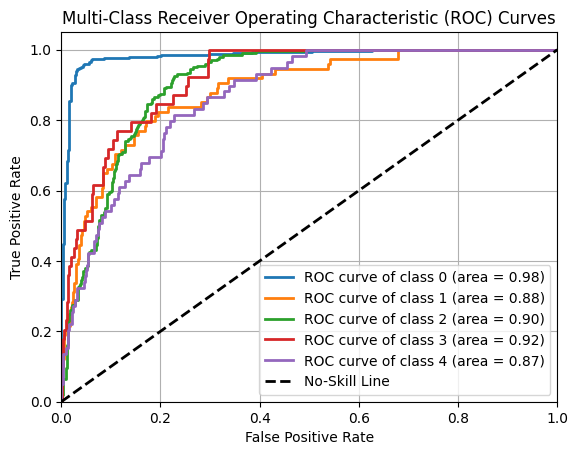

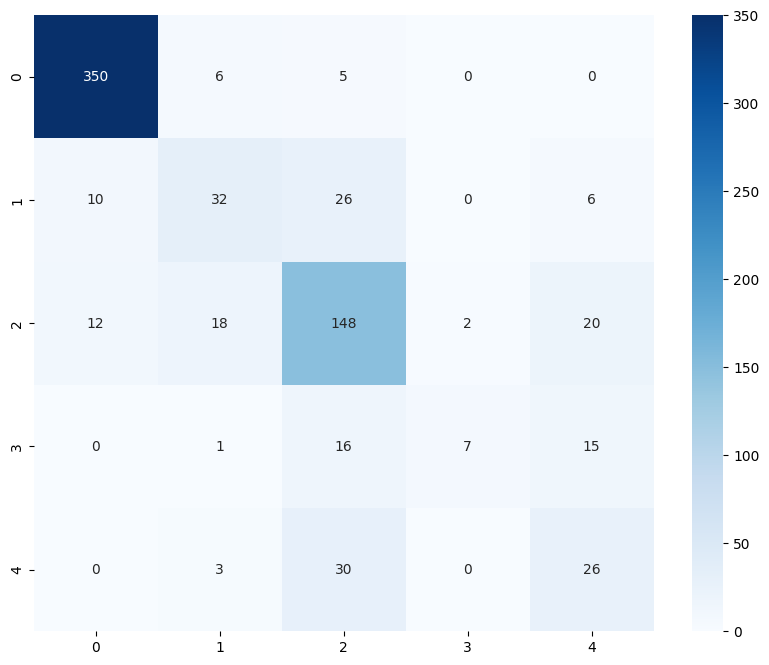

In [ ]:
evaluate(model_564258)

Generating predictions on the test set...
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Calculating evaluation metrics...
Cohen's Kappa (Quadratic Weighted):
0.820738137082601
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       361
           1       0.46      0.46      0.46        74
           2       0.65      0.74      0.69       200
           3       0.64      0.18      0.28        39
           4       0.50      0.36      0.42        59

    accuracy                           0.77       733
   macro avg       0.63      0.54      0.56       733
weighted avg       0.76      0.77      0.75       733

Confusion Matrix:
[[350   8   3   0   0]
 [ 11  34  28   0   1]
 [ 16  24 149   3   8]
 [  0   2  18   7  12]
 [  0   6  31   1  21]]
Basic loss and accuracy from model.evaluate:
[0.6327806711196899, 0.7653478980064392]
AUC Score:
0.9093610423696312


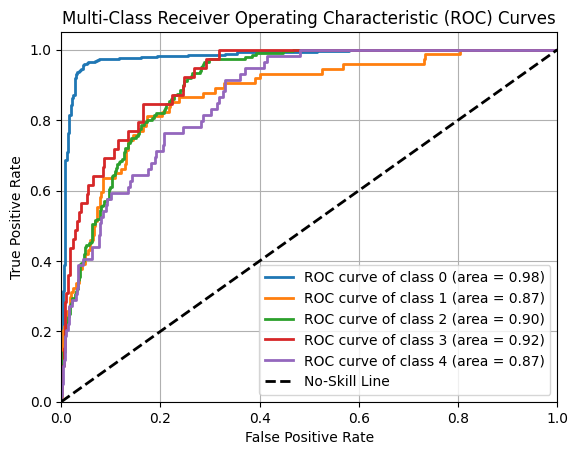

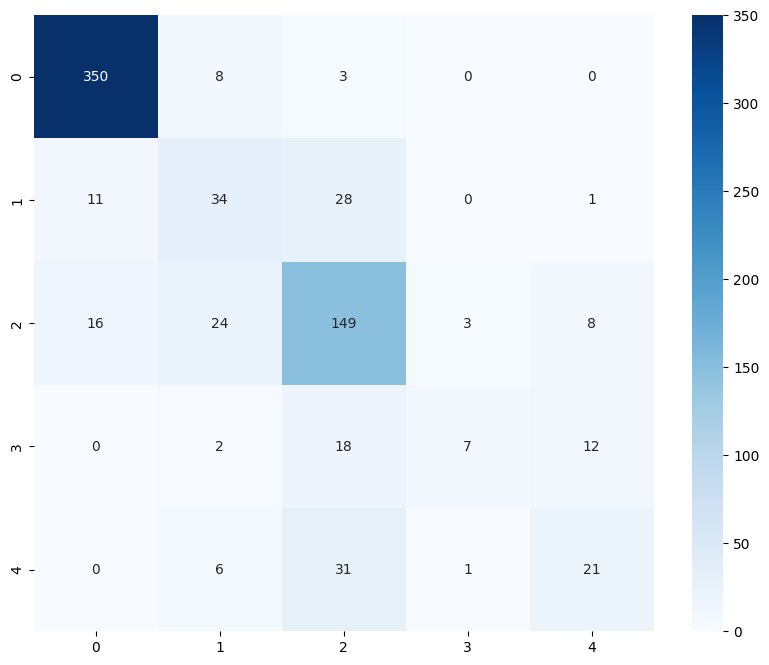

In [ ]:
evaluate(model_564307)

Generating predictions on the test set...
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Calculating evaluation metrics...
Cohen's Kappa (Quadratic Weighted):
0.8097220987500666
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       361
           1       0.51      0.54      0.52        74
           2       0.66      0.74      0.70       200
           3       0.50      0.15      0.24        39
           4       0.46      0.36      0.40        59

    accuracy                           0.77       733
   macro avg       0.61      0.55      0.56       733
weighted avg       0.75      0.77      0.75       733

Confusion Matrix:
[[347   8   6   0   0]
 [ 10  40  22   0   2]
 [ 13  23 148   5  11]
 [  0   1  20   6  12]
 [  1   7  29   1  21]]
Basic loss and accuracy from model.evaluate:
[0.6711835861206055, 0.7667121291160583]
AUC Score:
0.8994906106493465


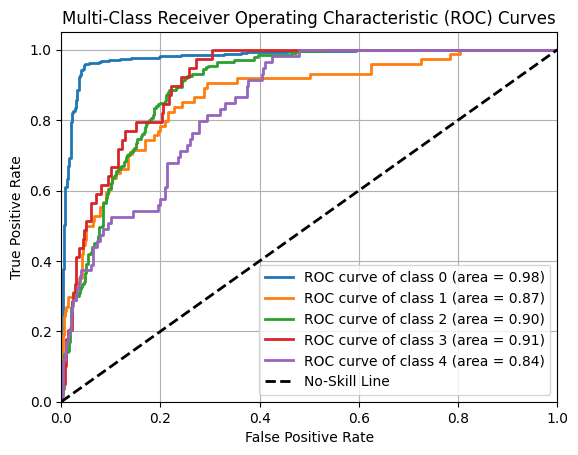

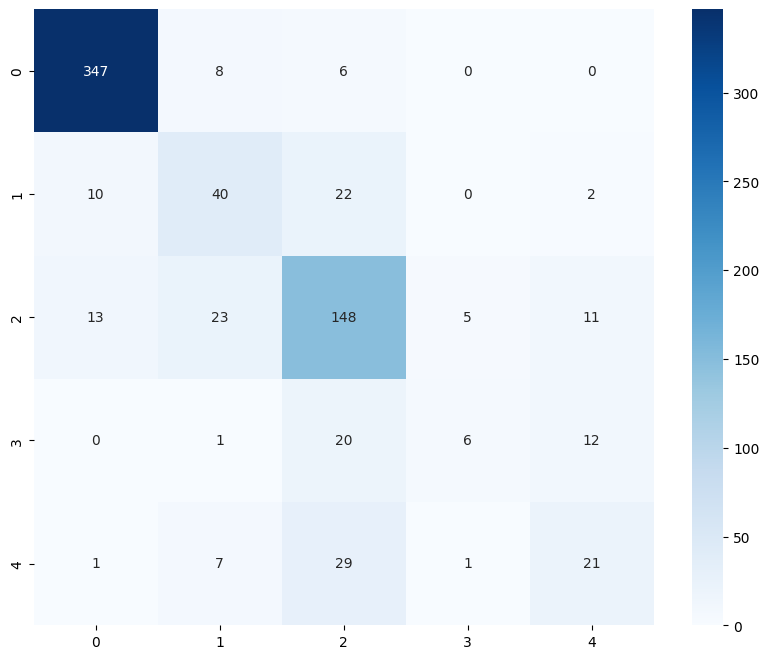

In [ ]:
evaluate(model_564322)

In [ ]:
model_564307 = keras.models.load_model('best_model_seed_564307.keras')
extract_features_model = keras.models.Model(
    inputs=model_564307.input,
    outputs=model_564307.get_layer('dropout_1').output
)
extract_features_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)